In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import re

bs = 64

# fixes fastai + pandas error
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
path = "data/"
df = pd.read_csv(f"{path}train.csv", low_memory=False)
df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [5]:
# Add value for sightings to ease creation of validation set
sighting_count = df[df['Id'] != 'new_whale'].Id.value_counts()
sighting_count.name = 'sightings'
df = df.join(sighting_count, on='Id')
df.head()

,Image,Id,sightings
0,00022e1a.jpg,w_e15442c,1.0
1,000466c4.jpg,w_1287fbc,34.0
2,00087b01.jpg,w_da2efe0,11.0
3,001296d5.jpg,w_19e5482,1.0
4,0014cfdf.jpg,w_f22f3e3,2.0


In [6]:
val_func = set(
    df.sample(frac=1)[(df['Id'] != 'new_whale') & (df['sightings'] > 1)].groupby('Id').first().Image
)

# add 700 new whales to the validation set
val_func = val_func.union(
    set(df[df['Id'] == 'new_whale'].sample(frac=1).Image.values[:700])
)

C:\Users\matt\Miniconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
len(val_func)

2730

In [8]:
func_to_label = { row[1].Image: row[1].Id for row in df.iterrows() }

path_to_func = lambda path: re.search('\w*\.jpg$', path).group(0)

In [7]:
data = (
    ImageItemList
        .from_df(df, path="data/train", cols=['Image'])
        .split_by_valid_func(lambda path: path_to_func(path) in val_func)
        .label_from_func(lambda path: func_to_label[path_to_func(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(
            get_transforms(
                do_flip=False,
                max_zoom=1,
                max_warp=0,
                max_rotate=2
            ),
            size=224,
            resize_method=ResizeMethod.SQUISH
        )
        .databunch(bs=64, path='data', num_workers=4)
        .normalize(imagenet_stats)
)

Wall time: 7.18 s


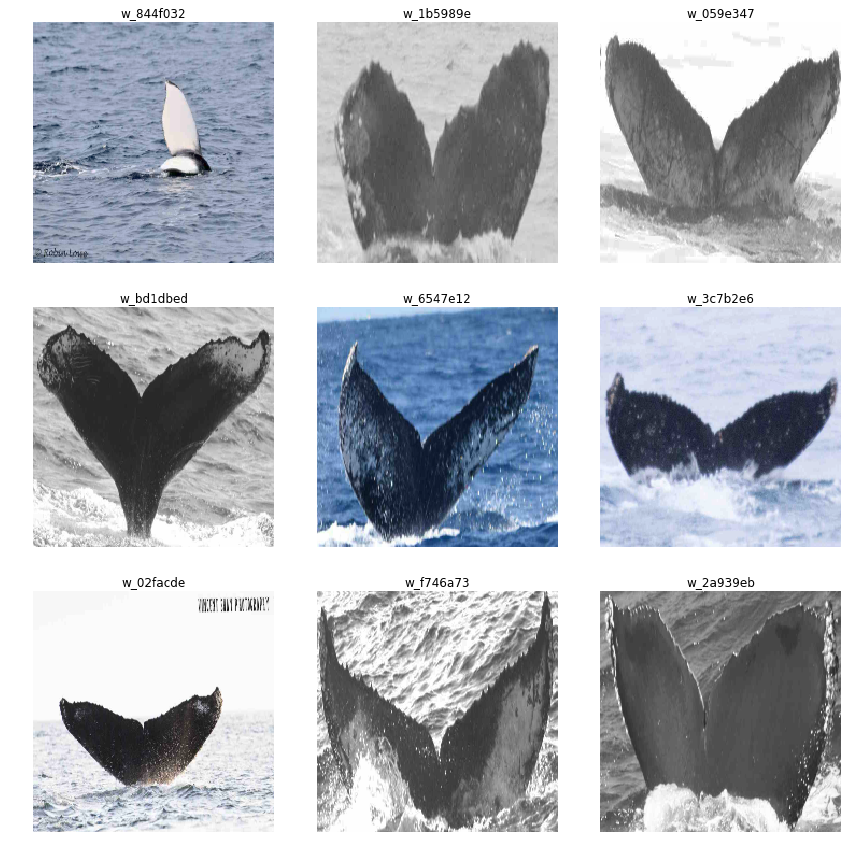

In [8]:
%%time
data.show_batch(rows=3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


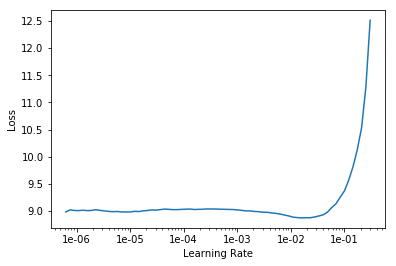

In [9]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], metrics=error_rate)
learn.clip_grad()

learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(10, 1e-2)
learn.save("resnet50-stage-1")

learn.unfreeze()
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)
learn.save("resnet50-stage-2")


# resize images and re-train
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 4
SEED=0

data = (
    ImageItemList
        .from_df(df, path="data/train", cols=['Image'])
        .split_by_valid_func(lambda path: path_to_func(path) in val_func)
        .label_from_func(lambda path: func_to_label[path_to_func(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(
            get_transforms(
                do_flip=False,
                max_zoom=1,
                max_warp=0,
                max_rotate=2
            ),
            size=SZ,
            resize_method=ResizeMethod.SQUISH
        )
        .databunch(bs=BS, path='data', num_workers=4)
        .normalize(imagenet_stats)
)

learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], metrics=error_rate)
learn.clip_grad()

learn.load('resnet50-stage-2')
learn.freeze_to(-1)

learn.fit_one_cycle(14, 1e-2 / 4)
learn.save('resnet50-stage-3')


learn.unfreeze()
max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(24, lrs)
learn.save('resnet50-stage-4')

epoch,train_loss,valid_loss,error_rate
1,8.232276,7.734827,0.969597
2,7.948679,8.198174,0.958242
3,7.703049,6.754298,0.878755
4,6.593313,6.389338,0.930769
5,4.903771,6.160977,0.868498
6,2.854342,5.581172,0.768498
7,1.131961,5.950882,0.747619
8,0.418883,5.437458,0.713919
9,0.150271,5.462187,0.706227
10,0.078510,5.408931,0.701099


epoch,train_loss,valid_loss,error_rate
1,0.061737,5.399861,0.698169
2,0.069137,5.453452,0.697436
3,0.089654,5.570753,0.707692
4,0.144301,5.646026,0.720513
5,0.157233,5.802349,0.740293
6,0.211477,5.878353,0.732967
7,0.183962,5.840359,0.726007
8,0.174070,5.962830,0.725275
9,0.139824,5.866777,0.721612
10,0.112035,5.851208,0.716850


epoch,train_loss,valid_loss,error_rate
1,1.688439,6.002276,0.752747
2,0.901782,5.624100,0.706227
3,1.381098,5.946442,0.719414
4,1.897251,6.330660,0.731502
5,1.777039,6.170506,0.722711
6,1.480706,6.112025,0.718681
7,1.096531,6.062892,0.699634
8,0.790839,5.950840,0.696337
9,0.521627,6.233389,0.693040
10,0.313119,6.052950,0.677289


epoch,train_loss,valid_loss,error_rate
1,0.057679,6.012209,0.665201
2,0.059124,5.967802,0.662637
3,0.052501,6.035898,0.669963
4,0.052186,6.125692,0.673626
5,0.097909,6.248174,0.671429
6,0.081525,6.135279,0.669963
7,0.103964,6.148386,0.675092
8,0.121518,6.168319,0.671062
9,0.105123,5.944725,0.671429
10,0.101338,6.111175,0.664103


In [9]:
df = pd.read_csv('data/oversampled.csv')
df.shape


(64681, 2)

In [10]:
data = (
    ImageItemList
        .from_df(df, path="data/train", cols=['Image'])
        .split_by_valid_func(lambda path: path_to_func(path) in val_func)
        .label_from_func(lambda path: func_to_label[path_to_func(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(
            get_transforms(
                do_flip=False,
                max_zoom=1,
                max_warp=0,
                max_rotate=2
            ),
            size=224,
            resize_method=ResizeMethod.SQUISH
        )
        .databunch(bs=64, path='data', num_workers=4)
        .normalize(imagenet_stats)
)

In [13]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
learn.load('resnet50-stage-4')
learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)
learn.save('resnet50-stage-5')

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(2, lrs)
learn.save('resnet50-stage-6')

epoch,train_loss,valid_loss
1,0.166706,3.101894
2,0.043121,2.912096


epoch,train_loss,valid_loss
1,0.034735,2.865197
2,0.020796,2.873510


In [14]:
preds, _ = learn.get_preds(DatasetType.Test)

preds = torch.cat((preds, torch.ones_like(preds[:,:1])), 1)

In [24]:
classes = learn.data.classes + ['new_whale']

In [25]:
submission = pd.DataFrame({
    'Image': [ path.name for path in data.test_ds.x.items ]
})

top_5_preds = np.argsort(preds.numpy())[:, ::-1][:, :5]
labels = []
for i in range(top_5_preds.shape[0]):
    labels.append(' '.join([classes[idx] for idx in top_5_preds[i]]))

submission['Id'] = labels

In [26]:
submission.head()

,Image,Id
0,00029b3a.jpg,new_whale w_251ee17 w_6da177a w_83034c7 w_7875b79
1,0003c693.jpg,new_whale w_0b775c1 w_e964ae8 new_whale w_62c548b
2,000bc353.jpg,new_whale w_43be268 new_whale w_95874a5 w_e54feba
3,0010a672.jpg,new_whale w_6af9dd7 w_8a98ddb w_b001dbe w_147b62b
4,00119c3f.jpg,new_whale w_e8bce8a w_b618751 w_9875c12 w_17e8554


In [27]:
submission.to_csv("submission.csv", index=False)

In [32]:
# since the competition is no longer accept submissions, let's just evaluate
learn.TTA(ds_type=DatasetType.Test)

(tensor([[1.6994e-04, 7.3556e-06, 7.1892e-06,  ..., 5.4730e-04, 1.6839e-04,
          1.1914e-06],
         [8.1263e-04, 9.3454e-08, 3.7386e-07,  ..., 2.6436e-06, 1.3242e-06,
          5.0411e-08],
         [5.6143e-02, 2.3637e-06, 6.3999e-06,  ..., 1.0753e-05, 6.8475e-04,
          1.4122e-05],
         ...,
         [2.1519e-02, 8.5343e-05, 2.6381e-06,  ..., 7.4843e-05, 4.1991e-05,
          1.7468e-04],
         [6.2210e-03, 5.0326e-05, 1.4393e-04,  ..., 1.4868e-02, 9.7891e-05,
          1.6188e-04],
         [3.7015e-03, 1.2184e-06, 2.5406e-06,  ..., 5.7373e-06, 9.7042e-06,
          4.0692e-06]]), tensor([0, 0, 0,  ..., 0, 0, 0]))